# Digits classifier

Let's build a model that is able to recognize digits 3 and 7.

In [270]:
# just uncomment below line if you're not sure you have this dependency in your environment
# %pip install fastbook

In [271]:
# loading and setting up dependencies
import fastbook

fastbook.setup_book()

from fastai.vision.all import *
from fastbook import *
from matplotlib import pyplot as plt
from torch.nn import functional as F

In [272]:
# import MNIST sample that only contains 3s and 7s
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path

path.ls()

(#3) [Path('valid'),Path('train'),Path('labels.csv')]

As you can see from the previous output, this dataset is organized into separate folders for training and validation sets.

In [273]:
# let's see what's inside the training set
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

We are confirming here that the training sample contains 7's and 3's only. These are our _labels_. Let's zoom in a little more.

In [274]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [275]:
# let's look at one image
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [276]:
# viewing the numbers that make up that image as a `NumPy` array

# selecting a subarray from rows 4 to 10 (not included) and columns 4 to 10 (not included)
# `numpy` indexes from top to bottom and left to right
array(im3)[4:10,4:10] 

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [277]:
# now let's do the same thing with a `pytorch` tensor
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

## `NumPy` arrays vs `PyTorch` tensors

`NumPy` arrays are multidimensional tables of data, with all items of the same type. `PyTorch` tensors are different in that they have to use a single basic numeric type for all components of the array and it cannot be _jagged_, e.g. containing arrays of different sizes in it.

One of the main features of `PyTorch` tensors, compared to `NumPy` arrays, is that they can be used on a GPU to accelerate computing. It is also able to compute gradients by keeping track of successive operations using the calculus chain rule.

In [278]:
# To create an array or tensor, pass a list (or list of lists, or list of lists of lists, etc.) to `array()` or `tensor()`:
data = [[1,2,3],[4,5,6]]
arr = array (data) # `NumPy`
tns = tensor(data) # `PyTorch`

tns

tensor([[1, 2, 3],
        [4, 5, 6]])

In [279]:
# to select a row of a tensor
tns[0]

tensor([1, 2, 3])

In [280]:
# to select a column of a tensor
tns[:, 1] # `:` here says "take all the values of the first axis"

tensor([2, 5])

In [281]:
# combination of the above using `slice` syntax
tns[1,1:3]

# this says "take the second row, then take columns 1 to 3 (not including 3)"


tensor([5, 6])

In [282]:
# `PyTorch` makes it very easy to perform arithmetic operations at scale
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

In [283]:
# all `PyTorch` tensors have a type
tns.type()

'torch.LongTensor'

In [284]:
# this type can change automatically based on the operations you perform
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

See the example below for a practical usage of a `PyTorch` tensor:

In [285]:
# let's slice the array and pick just the part with the top of the digit in it
im3_t = tensor(im3)

# let's make a data frame out of it
df = pd.DataFrame(im3_t[4:15,4:22])
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


In [286]:
# now let's color code the values
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## getting on with our baseline model

The _baseline_ of our classifier will be very simple, as it should be:

- find the average pixel value for every pixel of the 3s
- find the average pixel value for every pixel of the 7s

This gives us group averages that we may call "ideal" 3s and 7s. We would first classify a digit as a 3 if the average pixel value of the digit is closer to the ideal 3 than to the ideal 7, and vice versa.

In [287]:
# create tensors containing all 3s and 7s stacked together
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

<Axes: >

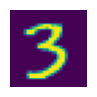

In [288]:
# Jupyter ships with a function called `show_image` that knows how to render a tensor as an image
show_image(three_tensors[1])

## rank-3 tensors

For every pixel position, we want to compute the average over all the images of the intensity of that pixel. 

To do this we first combine all the images in this list into a single three-dimensional tensor. 

The most common way to describe such a tensor is to call it a _rank-3 tensor_.

See an example of what that might look like below:

![rank-3 tensor.png](./rank-3-tensor.png)

A rank-3 tensor is essentially a cube of numbers.

To index a number of that tensor, you would need:

- the layer
- the row
- the column

### how did we conclude that we needed a rank-3 tensor?

- Each image is a 2d matrix of pixels (rows and columns, e.g. a _rank-2 tensor_)
- Each element in the matrix corresponds to a pixel intensity (a scalar value, e.g. a _rank-1 tensor_)
- To ease computing of the average of each pixel intensity over all images, you would stack each of these matrices on top of each other: there you have it, a _rank-3 tensor_

In [289]:
# let's our images and cast our stacked tensors as float tensors for further computation
# we also normaliste our pixel values to be between 0 and 1 by dividing by 255
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255

# a _shape_ tells us the length of each axis of a tensor
stacked_threes.shape

torch.Size([6131, 28, 28])

The previous output says to us: "we have 6131 images, each of size 28x28 pixels". 

We can define the _shape_ as **the size of each axis in a tensor**.

In [290]:
# the _length_ of a tensor's shape is its _rank_
len(stacked_threes.shape)

3

In [291]:
# you could also get the rank of a tensor like so
stacked_threes.ndim

3

The _dimension_ 0 of our rank-3 tensor is the number of images.

Here is how you would compute the average pixel intensity for each pixel position:

<Axes: >

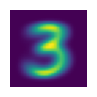

In [292]:
ideal3 = stacked_threes.mean(0)
show_image(ideal3)

<Axes: >

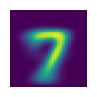

In [293]:
# let's do the same thing for the 7s
ideal7 = stacked_sevens.mean(0)
show_image(ideal7)

## Test the baseline model

Now that we have an idea of what our ideal 3 and 7 look like, we can try to classify our images. To test our baseline, we would pick an arbitrary number from the dataset and measure its distance from its _ideal_ representation.

<Axes: >

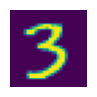

In [294]:
# here is our sample number for our test
a_3 = stacked_threes[1]
show_image(a_3)

To calculate the distance from the baseline `3`, we can't just add up the differences in intensity between each of the pixels of both images. It is so because some differences would cancel out (light vs dark pixels), and that would be misleading as very different pixels could have a value of zero, which would mean "no difference from the ideal digit representation".

There are two main ways data scientists measure distance in this context:

- take the mean absolute value of differences: this is called _mean absolute difference_ or _L1 norm_
- take the mean of the square of differences (which makes everything positive) and then take the square root (which undoes the squaring): this is called _root mean squared error_ or _L2 norm_

In [295]:
# let's try the `L1` norm
dist3_l1 = (a_3 - ideal3).abs().mean()

dist3_l1

tensor(0.1114)

In [296]:
# let's try the `L2` norm now
dist3_l2 = ((a_3 - ideal3)**2).mean().sqrt()

dist3_l2

tensor(0.2021)

In [297]:
# let's check if our arbitraty number is a 3 or a 7 using both methods

# `L1` norm
dist7_l1 = (a_3 - ideal7).abs().mean()
dist7_l1

tensor(0.1586)

In [298]:
# we'll use the `L2` norm
dist7_l2 = ((a_3 - ideal7)**2).mean().sqrt()
dist7_l2

tensor(0.3021)

From the little experiment we've just run, we can see that our baseline model predicts right in this particular case.

We could have done the same thing with `PyTorch`, which provides loss functions (among many other things), as shown below:

In [299]:
dist7_l1_torch = F.l1_loss(a_3.float(), ideal7)
dist7_l1_torch

tensor(0.1586)

In [300]:
dist7_l2_torch = F.mse_loss(a_3, ideal7).sqrt()
dist7_l2_torch

tensor(0.3021)

## L1 vs L2 norms

The main difference between L1 norm and MSE is that the latter will penalize bigger mistakes more heavily than the former, which may be more lenient with small mistakes.

## Defining a metric for our baseline model

A metric is a number that is calculated based on the predictions of our model, and the correct labels in our dataset, in order to tell us how good our model is.

In practice, _accuracy_ is a common metric for classification models.

- The _error rate_ in deep learning refers to the difference between the predicted output and the actual output of a neural network. It is a measure of how well the network is performing on a given task. In this context, _accuracy_ can be defined as `1.0 - error rate`.

A metric is always calculated over a _validation_ set.

To get a validation set, we need to remove some of the data of the training set entirely, so it's not seen by the model at all during training.

In [301]:
# let's create tensors for 3s and 7s using the MNIST validation set
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255

valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

# here we divided both tensors by 255 to normalize the pixel values between 0 and 1

# x images of size 28x28 pixels
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [302]:
# now let's write the function that will decide if a number is a 3 or a 7
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, ideal3)


tensor(0.1114)

## why `mean((-1,-2))`

The `mean` function in `PyTorch` can take a tuple of axes to take the mean of. In this case, we want to take the mean over the last two dimensions (in this case, the horizontal and vertical dimensions of an image).

The tuple `(-1,-2)` represents a range of axes.

This effectively allows us to make batch calculations on rank-3 tensors, as you will see in the example below.

In [303]:
# applying the same calculation for every image in our validation set
valid_3_dist = mnist_distance(valid_3_tens, ideal3)
valid_3_dist, valid_3_dist.shape

# for every image, we averaged the intensity of all pixels in that image;
# we are left with a rank-1 tensor of length 1010 after this operation

(tensor([0.1147, 0.1423, 0.1413,  ..., 0.1093, 0.1156, 0.1193]),
 torch.Size([1010]))

`PyTorch` is so versatile it didn't even complain about shapes not matching and calculated the distance for each image instead !

This is made possible because `PyTorch` uses _broadcasting_ under the hood: e.g. the ability expand a lower rank tensor to have the same size as a higher rank input tensor during a calculation. This is why this type of operation is possible:

```python
tensor([1,2,3]) + tensor(1) # tensor([2,3,4])
```

When applying the `abs()` function on a tensor, you get back a matrix of absolute values.

Now let's continue with the function that determines if the number is a `3` or a `7`:

In [304]:
def is_3(x): return mnist_distance(x,ideal3) < mnist_distance(x,ideal7)

# let's test the function
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [305]:
# let's do the same thing at scale
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

In [306]:
# again but as floats
is_3(valid_3_tens).float()

tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [307]:
# get the mean of correct predictions
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_3s

tensor(0.9168)

In [308]:
# let's do the above steps for 7s
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()
accuracy_7s

# we use the inverse here with `1 - is_3` because we want to know how many 7s we correctly identified (OR logic)

tensor(0.9854)

We can conclude from the above that we have a pretty good baseline for 2 numbers !

However, we are limited by the fact that we need to classify more than 2 numbers. This is where _Stochastic Gradient Descent_ (SGD) comes in.

## Introducing SGD

In our pixels similarity approach, we don't have any kind of weight assignment, or any way of improving our classifier based on testing the effectiveness of a weight assignment.

### A little aparté on weight assignment

Weights are just variables, and a weight assignment is a particular choice of values for those variables. The program's inputs are values that it processes in order to produce its results, for instance, taking image pixels as inputs and returning the classification "dog" as a result. The program's weight assignments are other values that define how the program will operate.

A traditional program takes input and outputs results, whereas a machine learning program takes inputs and weights to output its results. Another difference is that the _program_ is a set of conditionals, loops, etc. whereas the _model_ is a mathematical function that minimizes errors to improve its accuracy. This function:
  - takes the inputs
  - multiplies them by a set of weights (nowaydays called `parameters`)
  - adds them up
  - redoes this process
  - once it's done, it takes all the negative numbers and replaces them with 0s
  - it then takes these inputs to a next _layer_ and redoes the whole process

This is how a deep learning model works, in contrast of a more classic program, which does not have weights:

  ![deep learning training cycle](https://storage.googleapis.com/pips_resources_images/blog/deep_learning_training_cycle.png)

Adjusting the weights here should have be done in the goal of maximizing the model's performance. This adjustment can be done automatically. 

As you can see, we aslo differentiate `results` from `performance`. For instance, the results can be the classification of an image, and the performance can be the accuracy of the classification.
The _loss_ is what is used to provide a better set of weights to the model, e.g. the model should aim at making the loss smaller

At some point, we can decide that a model is trained, that is we've chosen our favorite weight assignment; you will generally include the weights as part of the model at the end of this process. You can also note that a trained model can be treated like any other computer program when the training is over, this leverages powerful APIs. Another thing to note: once the model is trained, predicting (_inference_) is faster than training.  

A neural network is a mathematical function that is extremely flexible and that depends on its weights.  Neural networks are powerful tools because they can solve a very wide array of problems just by finding the right weights.

Weights in an AI model are numerical values that define how strongly given inputs to a node or neuron influence its output, in other words, they are the _parameters_ that are learned during the training process.

Using neural networks gives the operator enough flexibility to focus his efforts on training the model, e.g. finding good weights assignments.

Weight assignment in deep learning is like giving each input a score that affects how much it influences the output. For example, if you have a neural network that predicts the price of a house based on its size and location, you might give more weight to the size than the location, because size is more important for the price. The weights are usually random numbers at first, but they change as the network learns from the data. The way you choose the initial weights can affect how well the network learns and performs.

One way to choose the initial weights is to use some rules based on the type of function that each node uses to calculate its output. For example, some functions are like switches that turn on or off depending on the input, while others are like curves that smoothly change from low to high. Different rules work better for different functions, so you have to match them accordingly.

_Stochastic gradient descent_ is a technique used to update the weights of a neural network in order to make it improve at any given task. Its power resides in the fact that it provides a way of finding weight values automatically.

### Using another approach to classify digits

Now, back to our problem.

Instead of trying to find the similarity between an image and an "ideal image," we could instead look at each individual pixel and come up with a set of weights for each one.

For instance, pixels toward the bottom right are not very likely to activate neurons for a 7, so they should have a low weight for a 7, but they are likely to be activated for an 8, so they should have a high weight for an 8. 

This can be represented as a function with a set of weight values for each possible category, for instance the probability of being the number 8 =>

```python
def pr_eight(image_vector, weights_vector): return (image_vector * weights_vector).sum()
```

Here, the image represented as a vector is basically "all the rows stacked up end to end on a single long line". With this kind of function, we just need some way to update the weights to make them better and better at distinguishing between digits: we want to find the specific values for the weights that cause the result of our function to be high for images that are actually 8s, and low for images that are not. Searching for the best weights is a way of searching for the best function that recognizes 8s.

These are the steps that will turn our function into a machine learning classifier:

1. _Initialize_ the weights with random values
2. For each image, use these weights to predict whether it appears to be a 3 or a 7
3. Based on these predictions, calculate how good the model is (its _loss_)
4. Calculate the _gradient_, which measures for each weight, how changing that weight would change the loss
  - The gradients will tell us how much we have to change each weight to make our model better
5. _Step_ (that is, _change_) all the weights based on that calculation
    - A simple way to figure out whether a weight should be increased a bit, or decreased a bit, would be just to try it: increase the weight by a small amount, and see if the loss goes up or down. Once you find the correct direction, you could then change that amount by a bit more, and a bit less, until you find an amount that works well. However, this is slow! As we will see, the magic of calculus allows us to directly figure out in which direction, and by roughly how much, to change each weight, without having to try all these small changes. The way to do this is by calculating gradients. This is just a performance optimization, we would get exactly the same results by using the slower manual process as well.
6. Go back to the step 2, and repeat the process
7. Iterate until you decide to stop the training process (for instance, because the model is good enough or you don't want to wait any longer)
  - Generally, you would want to stop the training process when the model stops improving or gets worse

These relatively simple steps are the basis for nearly all deep learning models.

Calculating gradients relies heavily on derivatives. 

Derivatives are a way of finding **the instantaneous rate of change** or **the slope** of a function at any given point. A derivative in calculus is a measure of how a function changes as its input changes. It's like the speedometer of a car; it tells you how fast you're going at any point in time. Derivatives calculate the change of a function, not it's value.

For example, if `f'(2) = 4`; this means several things:

- at `x = 2` the slope of the function `f(x)` is `4`
- we can interpret that any small change in `x` around `2` will increase `f(x)` 4 times as fast

When we know how a function changes, we know what we need to make its value smaller.

One important thing to be aware of is that our function has lots of weights that we need to adjust, so when we calculate the derivative we won't get back one number, but lots of them—a gradient for every weight. But there is nothing mathematically tricky here; you can calculate the derivative with respect to one weight, and treat all the other ones as constant, then repeat that for each other weight. This is how all of the gradients are calculated, for every weight.

Thankfully, `PyTorch` can automatically compute the derivative of nearly any function!

### Compute derivatives with `PyTorch`

Consider the statement below:

```python
xt = tensor(3.).requires_grad_()
```

This statement does 2 main things:

- creates a tensor `xt` with the value `3.`
- it enables the gradient computation with `requires_grad_()`: this has the effect of modfying the tensor so that `PyTorch` keeps track of the operations performed directly on it using a computation graph, this feature being later used to calculate the gradients (_automatic differentiation_)

Let's see this in action with a simple example.

In [309]:
# creating our tensor and enabling gradients computation
xt = torch.tensor(3.).requires_grad_()

# perform operations on the tensor using the example of a simple quadratic function
yt = xt**2

## let's compute the derivative of `yt` with respect to `xt` (backward propagation)
yt.backward()

# let's see the valuese of `xt`, its derivative (`gradient` in deep learning jargon), and `yt`;
# here, `xt.grad` is the derivative of `yt` with respect to `xt`
xt, xt.grad, yt

(tensor(3., requires_grad=True),
 tensor(6.),
 tensor(9., grad_fn=<PowBackward0>))

Using the `backward` method above refers to _backpropagation_, which is the process of calculating the derivative of each layer.

Let's do the same thing with more values.

In [310]:
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [311]:
# taking in a rank-1 tensor and returning a tensor with a scalar value (rank-0 tensor)
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [312]:
# let's get the gradients
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

As we have just seen, the gradients only tell us the slope of the function, but they don't tell us how we should adjust our weights. However it gives us useful indications:

- if the slope is very large, then that may suggest that we have more adjustments to do
- if the slope is very small, then that may suggest that we are close to the optimal value

### The notion of _learning rate_

The _learning rate_ is the number by which you multiply the gradients in a gradients descent.

Deciding how to change our weights based on the values of the gradients is an important part of the deep learning process. Nearly all approaches start with the basic idea of multiplying the gradient by some small number, called the learning rate (LR). The learning rate is often a number between 0.001 and 0.1, although it could be anything.

Deciding which learning rate to use is a trial and error process. If you make it too big, your model will diverge, which means it will get worse and worse. But if you make it too small, the model will eventually improve, but it will take forever to converge.

The _learning rate_ is a hyperparameter: it controls how much the program adjusts its parameters in response to the feedback it gets. To understand with an analogy:
  - imagine a robot trying to learn how to walk
  - the learning rate would be the size of the steps the robot takes
  - if the steps are too wide, the robot will fall (overcorrecting)
  - if the steps are too small, the robot will take a long time to learn and hardly make any progress (undercorrecting)

Here is a visual representation of an undercorrecting model:

![undercorrecting model](https://raw.githubusercontent.com/fastai/fastbook/823b69e00aa1e1c1a45fe88bd346f11e8f89c1ff//images/chapter2_small.svg)

And here are some overcorrecting models examples:

![overcorrecting model](https://raw.githubusercontent.com/fastai/fastbook/823b69e00aa1e1c1a45fe88bd346f11e8f89c1ff/images/chapter2_div.svg)

![overcorrecting model](https://raw.githubusercontent.com/fastai/fastbook/823b69e00aa1e1c1a45fe88bd346f11e8f89c1ff//images/chapter2_bouncy.svg)

... as you can see, the first one makes steps that are too big, resulting in a lousy performance, and the other bounces back and forth because of a step that may be a little too high, this would cause training to be very slow.

Adjusting the weights of our model can be then expressed as simply as:

```python	
weights -= gradient * lr
```

This what _stepping the weights_ actually means.

We use a substraction here to allow:

- in case the slope is positive, the weight to be decreased
- in case the slope is negative, the weight to be increased

Remember: our ultimate goal is to minimize the loss.

### SGD example with a synthetic model

Gradient descent basically means that for a function `y = ax^2 + bx +c`, we will repeatedly try to find the most optimal values for `a`, `b`, and `c` so that the function is the closest possible to the actual data points. 

This is done by calculating the gradient of the function, which is the slope of the function at a given point. The gradient tells us how much we need to change the values of `a`, `b`, and `c` to make the function closer to the data points. 

The goal here is to update the values of `a`, `b`, and `c` by subtracting the gradient from them. This process is repeated until the function converges to the optimal values of `a`, `b`, and `c`. This is how _loss_ is minimized.

Gradient descent is the foundation of deep learning: it iterates over and over again to set some parameters in order to make a function, the addition of lots of rectified linear units, match your data. SGD mainly relies on a lot of addition and multiplication.

Imagine you were measuring the spped of a roller coaster as it goes over the top of a hump. You would expect it to be fastest at the bottom, and slowest at the top, and then it would slow up again as it goes up the other side: you want to build a model of how the speed changes over time.

In [313]:
# let's use a scenario where we measure the speed of our roller coaster every 20 seconds
measurements_times = torch.arange(0,20).float(); 
measurements_times

# `torch.arange` is a function that returns a rank-1 tensor containing a range of values within the specified range

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

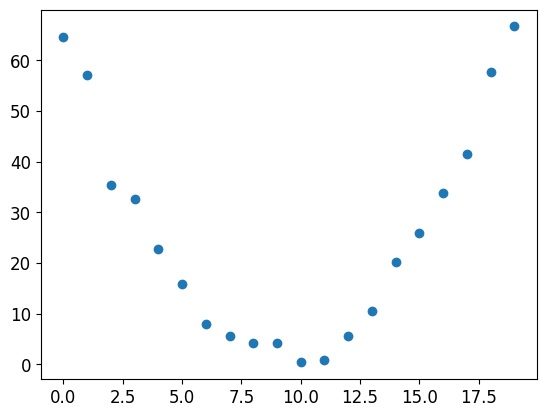

In [314]:
# let's simulate the measurements of the roller coaster's speed, we'll add some noise to the measurements,
# since these kinds of endeavors are never perfectly precise in real life
measurements_speed = torch.randn(20)*3 + 0.75*(measurements_times - 9.5)**2 + 1

plt.scatter(measurements_times, measurements_speed)

Since we've added noise, it's not that easy to answer the question: what was the roller coaster's speed at a given point ? Let's guess that the function that will give us the speed is a quadratic function, e.g. a function of the form `a*(time**2) + b*time + c`.

We want to cleary make the distinction between 2 things:

- the function's input, which is the time at which we measured the speed
- the function's parameters, which are the values `a`, `b` and `c`, e.g. the values that define _quadratic_ we're trying

Let's represent this idea in code, by separating the input from the parameters in our quadratic function signature:

In [315]:
def function_to_fit(function_input, function_params):
    a,b,c = function_params
    return a*(function_input**2) + (b*function_input) + c

What we are doing here is that we are trying to find the best imaginable function that fits the data. This is a simplification since, now, all we have to do is find the best values for `a`, `b` and `c`.

Solving this problem for 3 parameters of a quadratic function makes it possible to solve it for any number of parameters of any function.

To define what are the _best_ parameters parameters (weights) for our function, we need to define a _loss function_.

This function will return a value based on a prediction and a target. The lower the value, the better the prediction. For continuous data, it is common to use the mean squared error (MSE) loss function, which simply calculates the mean of the squared differences between the predictions and the targets.

In [316]:
def mse(preds, targets): return ((preds-targets)**2).mean()

Let's go back to our roller coaster example and redo the 7 steps we've seen earlier:

#### Step 1: initialize the weights

In [317]:
# random values at first + telling `PyTorch` to track gradients
weights = torch.randn(3).requires_grad_()
weights

tensor([ 1.0703, -1.2315, -1.0470], requires_grad=True)

#### Step 2: calculate the predictions

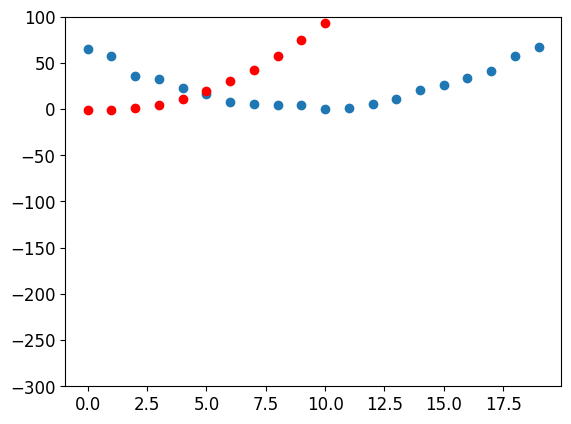

In [318]:
preds = function_to_fit(measurements_times, weights)

# function to see how close our predictions are to our targets
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    # plotting the actual values with blue dots
    ax.scatter(measurements_times, measurements_speed)
    # plotting the predictions with red dots
    ax.scatter(measurements_times, to_np(preds), color='red')
    ax.set_ylim(-300,100)

show_preds(preds)

As you can see, our model predicts a totally different roller coaster speed than the actual one...

We can know calculate the loss to try and improve our model.

#### Step 3: calculate the loss

In [319]:
loss = mse(preds, measurements_speed)
loss

tensor(20815.3965, grad_fn=<MeanBackward0>)

#### Step 4: calculate the gradients

In [320]:
loss.backward()
weights.grad

tensor([47684.3594,  3040.3884,   187.5511])

In [321]:
# let's give a shot at improving our parameters by picking a learning rate;
# for now, let's use `1e-5`, or `0.00001`
weights.grad * 1e-5

tensor([0.4768, 0.0304, 0.0019])

#### Step 5: step the weights

Let's update the parameters of our model using the gradients we've just calculated.

In [322]:
learning_rate = 1e-5
weights.data -= learning_rate * weights.grad.data
# we reset the gradients to zero after each step
weights.grad = None

# let's see how our predictions look now (if our loss has improved)
preds = function_to_fit(measurements_times, weights)
mse(preds, measurements_speed)

tensor(4434.2446, grad_fn=<MeanBackward0>)

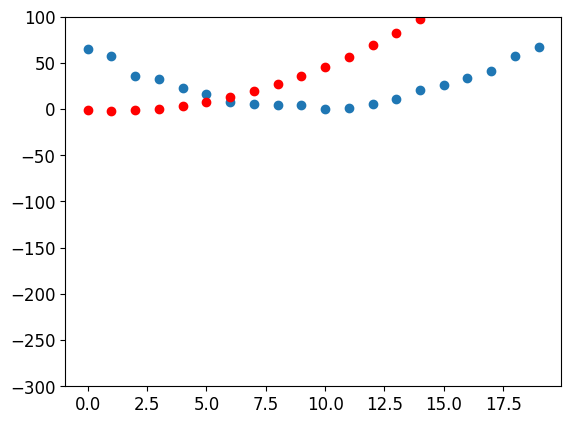

In [323]:
show_preds(preds)

It's better, but we obviously need to repeat the process a few times.

Let's create a function for this.

In [324]:
def apply_steps_2_to_5(weights, print_loss=True):
    preds = function_to_fit(measurements_times, weights)
    loss = mse(preds, measurements_speed)
    if print_loss: print(loss)
    loss.backward()
    learning_rate = 1e-5
    weights.data -= learning_rate * weights.grad.data
    weights.grad = None
    return preds

#### Step 6: repeat the process

In [325]:
for i in range(10): apply_steps_2_to_5(weights)

# we can see that the loss is decreasing, which means our predictions are getting better :)

tensor(4434.2446, grad_fn=<MeanBackward0>)
tensor(1334.4246, grad_fn=<MeanBackward0>)
tensor(747.8369, grad_fn=<MeanBackward0>)
tensor(636.8294, grad_fn=<MeanBackward0>)
tensor(615.8163, grad_fn=<MeanBackward0>)
tensor(611.8329, grad_fn=<MeanBackward0>)
tensor(611.0721, grad_fn=<MeanBackward0>)
tensor(610.9211, grad_fn=<MeanBackward0>)
tensor(610.8856, grad_fn=<MeanBackward0>)
tensor(610.8716, grad_fn=<MeanBackward0>)


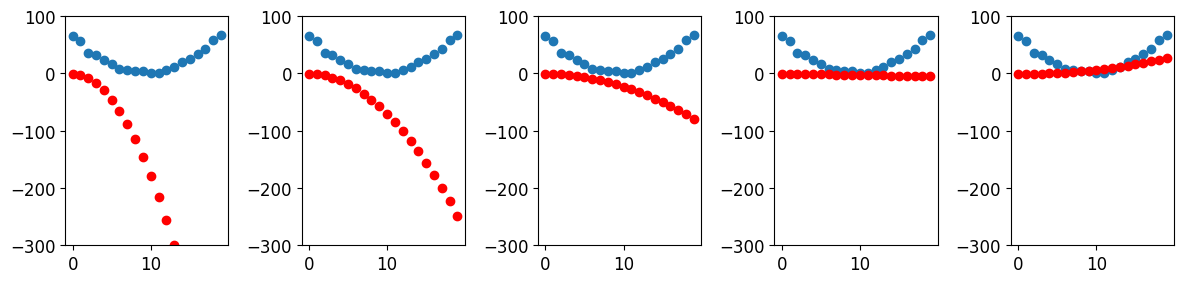

In [326]:
# for a better visual representation, let's plot the loss values
_,axs = plt.subplots(1,5,figsize=(12,3))
test_weights = torch.randn(3).requires_grad_()
for ax in axs: show_preds(apply_steps_2_to_5(test_weights, False), ax)
plt.tight_layout()

#### Step 7: stop the training process

We've decided to stop the training after 10 epochs arbitrarily. In practice, you would want to stop the training process when the model stops improving or gets worse. This means watching both training and validation loss, and stopping when the validation loss starts to increase (or at least, the rate of decrease slows down).

### SGD summary

<!-- TODO -->